## libstempo tutorial: basic functionality

#### Michele Vallisneri, vallis@vallis.org; latest revision: 2014/12/12 for v2 API

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from __future__ import print_function
import sys, math, numpy as N, matplotlib.pyplot as P

Load the libstempo Python extension. It requires a source installation of tempo2, as well as current Python and compiler, and the numpy and Cython packages.

(Both Python 2.7 and 3.4 are supported; this means that in Python 2.7 all returned strings will be unicode strings, while in Python 3 all function arguments should be default unicode strings rather than `bytes`. This should work transparently, although there are limitations to what characters can be passed to tempo2; you should probably restrain yourself to ASCII.

In [3]:
from libstempo.libstempo import *

In [4]:
import libstempo as T

T.data = T.__path__[0] + '/data/' # example files

In [5]:
print("Python version   :",sys.version.split()[0])
print("libstempo version:",T.__version__)
print("Tempo2 version   :",T.libstempo.tempo2version())

Python version   : 2.7.10
libstempo version: 2.2.5
Tempo2 version   : 2015.9


We load a single-pulsar object. Doing this will automatically run the tempo2 fit routine once.

In [6]:
psr = T.tempopulsar(parfile = T.data + '/J1909-3744_NANOGrav_dfg+12.par',
                    timfile = T.data + '/J1909-3744_NANOGrav_dfg+12.tim')

Let's start simple: what is the name of this pulsar? (You can change it, by the way.)

In [7]:
psr.name

'1909-3744'

Next, let's look at observations: there are `psr.nobs` of them; we can get numpy arrays of the site TOAs [in MJDs] with `psr.stoas`, of the TOA measurement errors [in microseconds] with `psr.toaerrs`, and of the measurement frequencies with `psr.freqs`. These arrays are *views* of the tempo2 data, so you can write to them (but you cannot currently change the number of observations).

In [8]:
psr.nobs

1001

In [9]:
psr.stoas

array([ 53292.017,  53292.048,  53355.834, ...,  54641.173,  54706.993,
        54764.835], dtype=float128)

In [10]:
psr.toaerrs

array([ 1.231,  4.668,  0.453, ...,  0.158,  1.336,  0.316])

In [11]:
psr.freqs

array([ 1372.,  1372.,  1372., ...,   884.,   884.,   884.])

By contrast, barycentric TOAs and frequencies are computed on the basis of current pulsar parameters, so you get them by calling `psr` *methods* (with parentheses), and you get a *copy* of the current values. Writing to it has no effect on the tempo2 data.

In [12]:
psr.toas()

array([ 53292.017,  53292.048,  53355.829, ...,  54641.18,  54706.997,
        54764.834], dtype=float128)

In [13]:
psr.ssbfreqs()

array([  1.37213133e+09,   1.37213155e+09,   1.37204346e+09, ...,
         8.83982927e+08,   8.84066115e+08,   8.84080037e+08])

Residuals (in seconds) are returned by residuals(). The method takes a few options... I'll let its docstring help describe them. libstempo is fully documented in this way (try `help(T.tempopulsar)`). 

In [14]:
help(psr.residuals)

Help on built-in function residuals:

residuals(...)
    tempopulsar.residuals(updatebats=True,formresiduals=True,removemean=True)
    
    Returns residuals as a numpy.longdouble array (a copy of current values).
    Will update TOAs/recompute residuals if `updatebats`/`formresiduals` is True
    (default for both). Will remove residual mean if `removemean` is True;
    first residual if `removemean` is 'first'; weighted residual mean
    if `removemean` is 'weighted'.



In [15]:
psr.residuals()

array([-1.1797189e-07,  7.1731513e-06,  1.0669245e-06, ...,  4.052052e-07,
        1.4198858e-06, -4.9935789e-07], dtype=float128)

We can plot TOAs vs. residuals, but we should first sort the arrays; otherwise the array follow the order in the tim file, which may not be chronological.

/Users/jaellis/Envs/dev/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


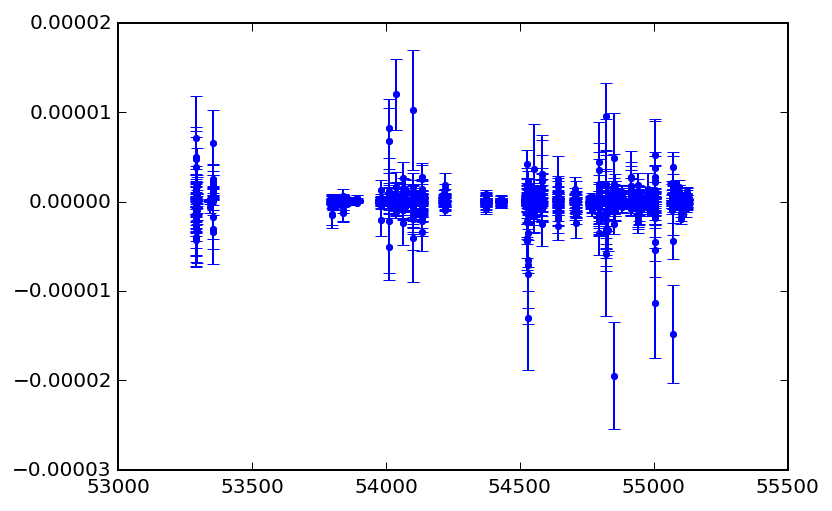

In [16]:
# get sorted array of indices
i = N.argsort(psr.toas())
# use numpy fancy indexing to order residuals 
P.errorbar(psr.toas()[i],psr.residuals()[i],yerr=1e-6*psr.toaerrs[i],fmt='.');

We can also see what flags have been set on the observations, and what their values are. The latter returns a numpy vector of strings. *Flags are not currently writable.*

In [17]:
psr.flags()

['fe', 'be', 'B', 'bw', 'tobs', 'pta', 'proc', 'chanid']

In [18]:
psr.flagvals('chanid')

array(['gasp_1372', 'gasp_1372', 'gasp_1372', ..., 'gasp_884', 'gasp_884',
       'gasp_884'], 
      dtype='|S32')

In fact, there's a commodity routine in `libstempo.plot` to plot residuals, taking flags into account.

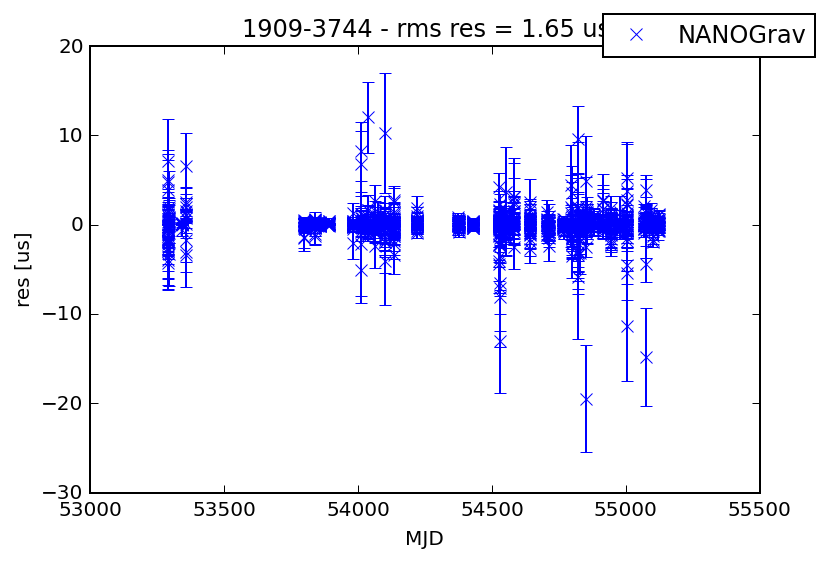

In [19]:
import libstempo.plot as LP

LP.plotres(psr,group='pta')

Timing-model parameters can be accessed by using psr as a Python dictionary. Each parameter is a special object with properties `val`, `err` (as well as `fit`, which is true is the parameter is currently being fitted, and `set`, which is true if the parameter was assigned a value).

In [20]:
psr['RAJ'].val, psr['RAJ'].err, psr['RAJ'].fit, psr['RAJ'].set

(5.0169080674060326785, 7.7537595250585651792e-10, True, True)

The names of all fitted parameters, of all set parameters, and of *all* parameters are returned by `psr.pars(which='fit')`. We show only the first few.

In [21]:
fitpars = psr.pars() # defaults to fitted parameters
setpars = psr.pars(which='set')
allpars = psr.pars(which='all')

print(len(fitpars),len(setpars),len(allpars))
print(fitpars[:10])

82 157 1942
('RAJ', 'DECJ', 'F0', 'F1', 'PMRA', 'PMDEC', 'PX', 'SINI', 'PB', 'A1')


The number of fitting parameters is psr.ndim.

In [22]:
psr.ndim

82

Changing the parameter values results in different residuals.

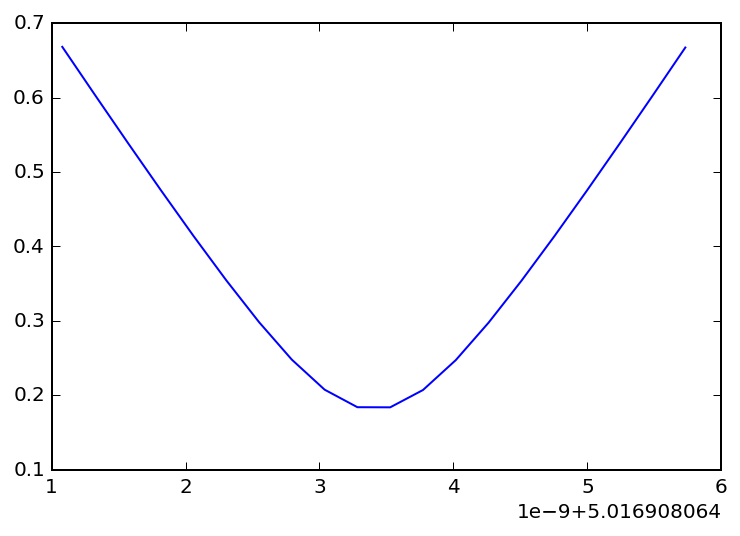

In [23]:
# look +/- 3 sigmas around the current value
x0, dx = psr['RAJ'].val, psr['RAJ'].err
xs = x0 + dx * N.linspace(-3,3,20)         

res = []
for x in xs:
    psr['RAJ'].val = x
    res.append(psr.rms()/1e-6)
psr['RAJ'].val = x0                       # restore the original value

P.plot(xs,res)

We can also call the tempo2 fitting routine, which will fit around the current parameter values, replacing them with their new best values. Individual parameters can be included or excluded in the fitting by setting their 'fit' field

In [24]:
psr['DM'].fit

False

In [25]:
psr['DM'].fit = True
print(psr['DM'].val)

10.39468


In [26]:
psr.fit()

In [27]:
print(psr['DM'].val,psr['DM'].err)

12.5074060904 3.4182310509


The tempo2-computed chi squared and rms is available as `psr.fitchisq`; it can also be recomputed by `psr.chisq()` (which evaluates `N.sum(psr.residuals()**2 / (1e-12 * psr.toaerrs**2))`). 

The pulsar parameters can be read in bulk by calling `psr.vals(which='fit')`, which will default to fitted parameters, but can also be given `'all'`, `'set'`, or even a list of parameter names.

In [28]:
fitvals = psr.vals()
print(fitvals)

[ 5.0169081 -0.65864032  339.31569 -1.6147938e-15  12.507406 -9.6109035
 -35.564441  0.11931759  0.99879959  1.5334495  1.897991  53113.951
 -4.1739624e-08 -2.7318448e-07  0.21266298 -0.00046599378 -0.0013589445
 -0.0015748093 -0.0015851235 -0.0015548348 -0.00091962792 -0.00083849129
 -0.00084040379 -0.001294838 -0.0013258244 -0.0017921981 -0.0019559173
 -0.0011218001 -0.0013477823 -0.0019284206 -0.0019655472 -0.0019575498
 -0.0018453676 -0.0013732464 -0.0013149195 -0.0015068398 -0.0019486041
 -0.0021363014 -0.0023016937 -0.0024131628 -0.0023472457 -0.0022844167
 -0.0021288281 -0.0018202295 -0.001530103 -0.0016850118 -2.6916452e-05
 -5.3743605e-05 -8.0432295e-05 -0.00010682855 -0.00013290467 -0.00015879522
 -0.00018451257 -0.00020986777 -0.00023508343 -0.0002601198 -0.00028497531
 -0.0003095673 -0.00033390548 -0.00035813228 -0.00038215617  0.0093207614
  0.0090426141  0.0089066344  0.0087726129  0.0086406512  0.0083824448
  0.0082563224  0.0081318643  0.0080091722  0.0078881904  0.0077

In [29]:
psr.vals(which=['RAJ','DECJ','PMRA'])

array([ 5.0169081, -0.65864032, -9.6109035], dtype=float128)

To set parameter values in bulk, you give a first argument to `vals`. Or call it with a dictionary. 

In [30]:
psr.vals([5.1,-0.6],which=['RAJ','DECJ','PMRA'])
psr.vals({'PMRA': -9.5})

print(psr.vals(which=['RAJ','DECJ','PMRA']))

# restore original values
psr.vals(fitvals)

[ 5.1 -0.6 -9.5]


Be careful about loss of precision; `tempopar.val` is a numpy longdouble, so you should be careful about assigning it a regular Python double. By contrast, doing arithmetics with numpy longdoubles will preserve their nature and precision.

You can access errors in a similar way with `psr.errs(...)`.

It's also possible to obtain the design matrix computed at the current parameter values, which has shape `psr.nobs * (len(psr.pars) + 1)`, since a constant offset is always included among the fitting parameters.

In [31]:
d = psr.designmatrix()

These, for instance, are the derivatives with respect to RAJ and DECJ, evaluated at the TOAs.

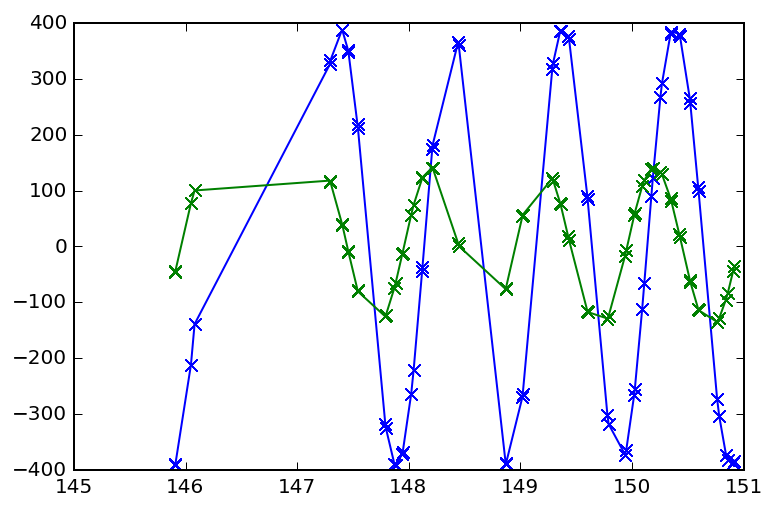

In [32]:
# we need the sorted-index array compute above
P.plot(psr.toas()[i]/365.25,d[i,1],'-x'); P.hold(True)
P.plot(psr.toas()[i]/365.25,d[i,2],'-x')

It's easy to save the current timing-model to a new par file. Omitting the argument will overwrite the original parfile.

In [33]:
psr.savepar('./foo.par')

In [34]:
!head foo.par

PSRJ           1909-3744
RAJ             19:09:47.4380320         1  0.00001067137985985063   
DECJ           -37:44:14.31897           1  0.00045633106886055894   
F0             339.31569275867931981     1  0.00000000000381385971   
F1             -1.6147938063967913066e-15 1  3.2219349503240919077e-20
PEPOCH         53000                       
POSEPOCH       53000                       
DMEPOCH        53000                       
DM             12.50740609040493764      1  3.41823105090290857433   
PMRA           -9.61090350999854007      1  0.03081051329588547355   


Same for writing tim files.

In [35]:
psr.savetim('./foo.tim')

In [36]:
!head foo.tim

FORMAT 1
MODE 1
 53292.000004.1.000.000.tsum 1372.00000000 53292.01653552588140172 1.23100 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 901.322 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53292.000010.1.000.000.tsum 1372.00000000 53292.04810962983469835 4.66800 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 901.322 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53355.000005.1.000.000.tsum 1372.00000000 53355.83359727578050169 0.45300 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 1081.587 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53800.000018.1.000.000.tsum 1372.00000000 53800.48353665754979858 0.14800 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 3424.969 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53838.000020.1.000.000.tsum 1372.00000000 53838.37506136744340068 0.54300 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 3064.446 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53858.000028.1.000.000.tsum 1372.00000000 53858.31918408581089963 0.08900 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -to

With libstempo, it's easy to replicate some of the "toasim" plugin functionality. By subtracting the residuals from the site TOAs (psr.stoas, vs. the barycentered psr.toas) and refitting, we can create a "perfect" timing solution. (Note that 1 ns is roughly tempo2's claimed accuracy.)

In [37]:
print(math.sqrt(N.mean(psr.residuals()**2)) / 1e-6)

1.79083682067


In [38]:
psr.stoas[:] -= psr.residuals() / 86400.0
psr.fit()

In [39]:
print(math.sqrt(N.mean(psr.residuals()**2)) / 1e-6)

0.000524152527002


Then we can add, e.g., homoskedastic white measurement noise at 100 ns (remember the tempo units: days for TOAs, us for errors, s for residuals).

In [40]:
psr.stoas[:] += 0.1e-6 * N.random.randn(psr.nobs) / 86400.0
psr.toaerrs[:] = 0.1
psr.fit()

<Container object of 3 artists>

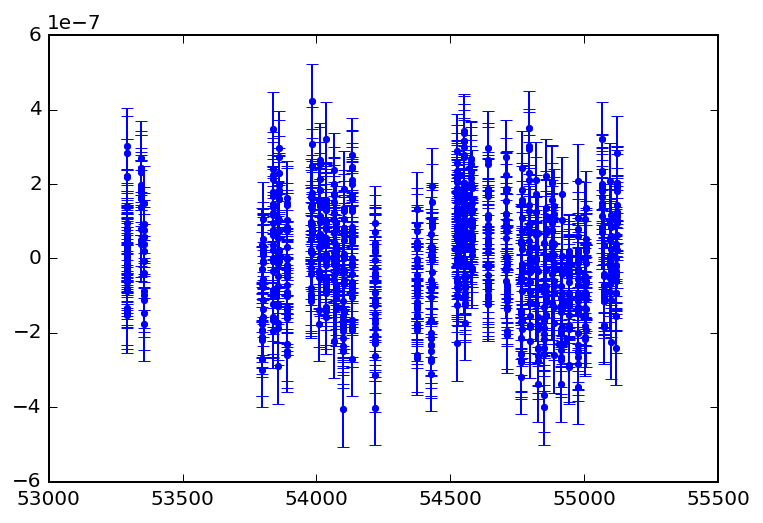

In [41]:
i = N.argsort(psr.toas())
P.errorbar(psr.toas()[i],psr.residuals()[i],yerr=1e-6*psr.toaerrs[i],fmt='.')

In [57]:
psr = T.tempopulsar(parfile = T.data + '/J1909-3744_NANOGrav_dfg+12.par',
                    timfile = T.data + '/J1909-3744_NANOGrav_dfg+12.tim')
#psr.fit()
print(psr.ephemeris)

psr2 = T.tempopulsar(parfile = T.data + '/J1909-3744_NANOGrav_dfg+12.par',
                    timfile = T.data + '/J1909-3744_NANOGrav_dfg+12.tim', )
psr2.ephemeris = 'DE418'
psr2.formbats()
#psr2.fit()


psr3 = T.tempopulsar(parfile = T.data + '/J1909-3744_NANOGrav_dfg+12.par',
                    timfile = T.data + '/J1909-3744_NANOGrav_dfg+12.tim')
psr3.ephemeris = 'DE421'
psr3.formbats()
#psr3.fit()


DE405


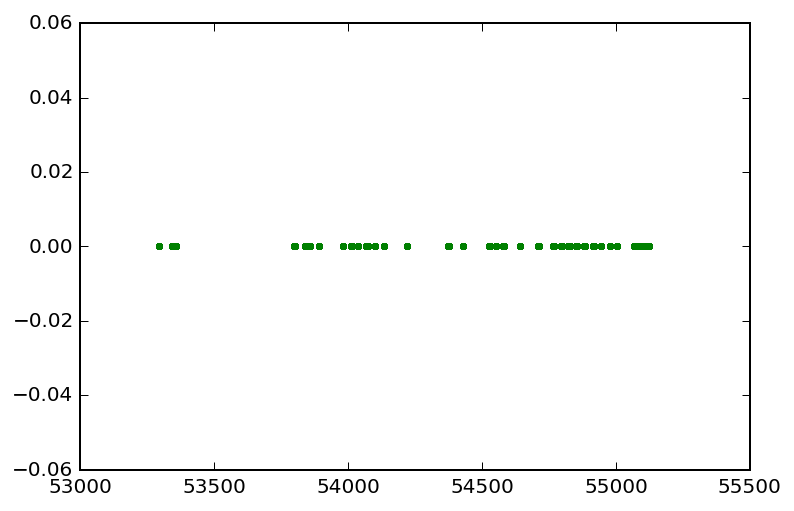

In [56]:
P.plot(psr.toas(), psr.residuals()-psr2.residuals(), '.')
P.plot(psr.toas(), psr.residuals()-psr3.residuals(), '.')

In [ ]:
x = 'jdjdj'
x.encode()